In [1]:
import tensorflow as tf
from os import path
import sys
tf.logging.set_verbosity(tf.logging.ERROR)
sys.path.append(path.join(".."))

In [2]:
%%html
<style>
table {
    float: left;
}

.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>

In this example, we used two datasets of mouse brain cells. For gene markers, we used the Panglao Cell Type Marker database.

We used the Hrvatin (2018) dataset for training the neural network (NN) because it has more cells and classes, and we used the Chen (2017) dataset for testing purposes because all of its classes are present in the Hrvatin dataset.

In [3]:
EPOCHS = 50

In [4]:
import saly
import saly.backend as S
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


SPECIES = 'Mouse'
DATA_PATH = '/home/mlongar/Data/SingleCellGeneExpression/'
#DATA_PATH = '/Users/MarkDavidLongar/Documents/Coding/MachineLearning/Data/'
#DATA_PATH = 'D:/Data/SingleCellGeneExpression/'
DATASET_HRVATIN_PATH = DATA_PATH + 'hrvatin_2018.h5ad' 
DATASET_CHEN_PATH = DATA_PATH + 'chen_2017.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

Using TensorFlow backend.


# Load the data

In [5]:
hrvatin_data, hrvatin_labels = saly.load_h5ad(DATASET_HRVATIN_PATH)
chen_data, chen_labels = saly.load_h5ad(DATASET_CHEN_PATH)

### Hrvatin

In [7]:
print(hrvatin_data.shape)
hrvatin_labels.unique()

(48266, 25186)


[Neuron, Oligodendrocyte, Muscle cell, Astrocyte, Endothelial cell, Macrophage, Microglia, OPC, Pericyte]
Categories (9, object): [Neuron, Oligodendrocyte, Muscle cell, Astrocyte, ..., Macrophage, Microglia, OPC, Pericyte]

Hrvatin has 48 266 cells and 25 186 genes.

The cells are classified into 9 classes: Neuron, Oligodendrocyte, Muscle cell, Astrocyte, Endothelial cell, Macrophage, Microglia, OPC and Pericyte.

### Chen

In [9]:
print(chen_data.shape)
chen_labels.unique()

(14437, 23284)


[tanycyte, Neuron, unknown, ependymal cell, Oligodendrocyte, epithelial cell, OPC, Astrocyte, Microglia, Macrophage]
Categories (10, object): [tanycyte, Neuron, unknown, ependymal cell, ..., OPC, Astrocyte, Microglia, Macrophage]

Chen has 14 437 cells and 39 851 genes.

The cells are classified into 10 classes: tanycyte, Neuron, unknown, ependymal cell, Oligodendrocyte, epithelial cell, OPC, Astrocyte, Microglia and Macrophage.

# Drop rows

We removed every cell classified as 'unknown' from the Chen dataset and we also removed every cell type not found in the Hrvatin data set.

In [10]:
chen_data, chen_labels = saly.drop_rows(chen_data, chen_labels, ['tanycyte', 'unknown', 'ependymal cell', 'epithelial cell'])

Dropped 4750 cell(s). New shape: (9687, 23284)


This removed 4750  cells from Chen, leaving us with 9687 left.

# Load marker genes

We make sure to only load the Human marker genes.

In [11]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)

#### Get the markers and only keep those found in both datasets

In [12]:
markers = saly.get_mutual_markers([hrvatin_data.columns, chen_data.columns], markers_db)

We do this because we want to train the network only on the marker genes found in both datasets, and drop the rest.

In [13]:
print(len(S.get_used_markers(hrvatin_data.columns, markers_db)), len(S.get_used_markers(chen_data.columns, markers_db)))
print(len(markers))

7675 7477
7390


Hrvatin has 7675  markers, and Chen has 7477.

We used only those found in both datasets (7390).

*Note that in this context* ***Marker ≠ Marker Gene*** *because multiple cell types (i.e. markers) can have the same marker gene and so in this context, the number 7545 means 7545 connections in the partially-connected Marker Layer between the cell types and the genes.*

### Make sure every class is in the marker layer

Because some cell types are differently labelled in the marker database, we created a dictionary of aliases.

We also make sure to print out any label that cannot be found in either the list of markers or in the dictionary of aliases.

In [14]:
marker_aliases = {'Neuron' : 'Neurons',
                'Oligodendrocyte' : 'Oligodendrocytes',
                'Muscle cell' : 'Smooth muscle cells',
                'Endothelial cell' : 'Endothelial cells',
                'Astrocyte' : 'Astrocytes',
                'Macrophage' : 'Macrophages',
                'OPC' : 'Oligodendrocyte progenitor cells',
                'Pericyte' : 'Pericytes'}

saly.check_labels([hrvatin_labels, chen_labels], markers, marker_aliases)

# Drop unused genes

We used only the genes found in both datasets and the marker gene database, and therefore, we will connect with the partially-connected marker layer.

In [15]:
hrvatin_data = saly.drop_unused_genes(hrvatin_data, markers)
chen_data = saly.drop_unused_genes(chen_data, markers)

Dropped 21104 gene(s). New shape: (48266, 4082)
Dropped 19202 gene(s). New shape: (9687, 4082)


After this operation we are left with 4082 genes.

#### Make sure the data sets' shapes match

In [16]:
saly.check_shape([hrvatin_data, chen_data])

# Data transformation

#### Preprocess the data

We shuffle, log10 transform and split the data into 70%, 15%, 15% splits.

In [17]:
(train_x, train_y), (validation_x, validation_y), (test_x, test_y) = saly.preprocess_data(hrvatin_data, hrvatin_labels,
                                                                                          train=0.7, validation=0.15,
                                                                                          test=0.15)

#### Log10 transform the Chen data, too

In [18]:
chen_data = S.log_10(chen_data)

# Building the model

For the model we define a partially-connected Marker Layer.

The layer has a node for each cell type whose genes are present in both data sets.
In this case, there are 179 nodes in the marker layer representing 179 cell types. 

We only connect nodes (i.e. the cell types) in the marker layer to their marker genes at the input.

We constructed the partially connected marker layer by taking a dense layer and adding a connection mask (a binary matrix) to it, which we multiply with the output matrix.

We trained the network for 100 epochs.

For training the network we used two losses:

    1) A loss that measured the network's classification accuracy (cross entropy)
    
    2) A loss that measured the network's reconstruction accuracy (mean square error)
           During training we scaled the MSE score 100x to compensate for the losses' different scales

### The Architecture
|Layer|Nodes|
|-----|------|
|Input|4082 (genes)|
|Markers|179 (cell types)|
|Dense layer|100|
|**Bottleneck**|**25**|
|Dense layer|100|
|*Dropout*|*10%*|
|Output|4082 (genes)|

#### Create the model

In [20]:
model, marker_model, encoder_model = saly.build_model(hrvatin_data, markers);

# Train the model

In [22]:
history = saly.train_model(model, train_x, train_y, markers, marker_aliases,
                           EPOCHS, validation_data=(validation_x, validation_y), verbose=0);

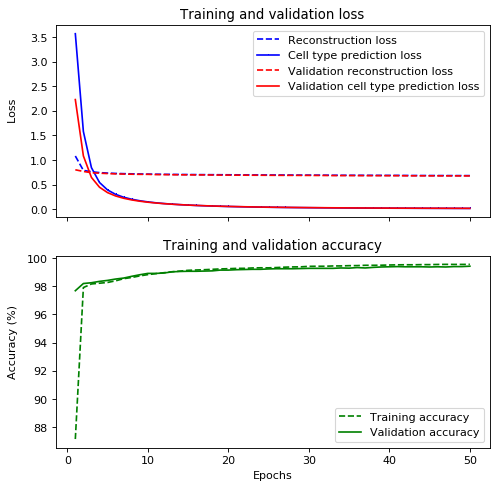

Test reconstruction loss: 0.00678267
Test prediction accuracy: 99.51 %


In [23]:
saly.plot_model_history(history)
saly.test_model(model, test_x, test_y, markers, marker_aliases);

# Data analysis

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE()
colours = S.load_label_colours('Data/hrvatin_chen_label_colours.pickle') 

## Hrvatin predictions

In [25]:
hrvatin_cell_activations = marker_model.predict(test_x)
hrvatin_bottleneck_activations = encoder_model.predict(test_x)

The graph below shows the mean cell type activations. Note that only one cell type explicitly activates.

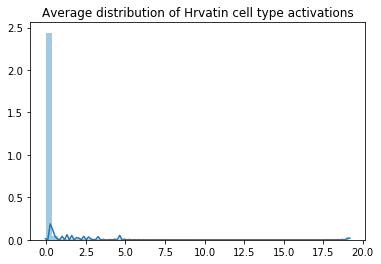

In [31]:
saly.plot_activation_distribution(hrvatin_cell_activations, markers,
                                  title='Average distribution of Hrvatin cell type activations')

In [26]:
saly.get_results(test_y, hrvatin_cell_activations, markers, marker_aliases)

Correct predictions: 14409 out of 14480 (99.51%)


The network correctly classifies 97% of test data from the training database.

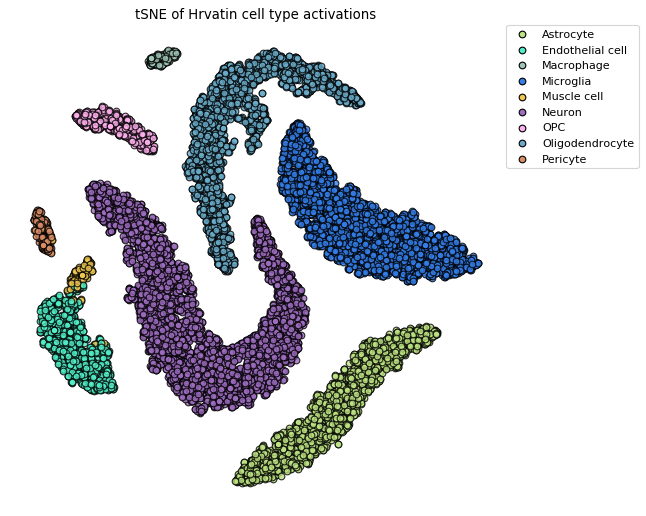

In [34]:
saly.draw_embedding(hrvatin_cell_activations, test_y, tsne, colours=colours, alpha=0.8,
                    graph_title='tSNE of Hrvatin cell type activations');

## Chen predictions

In [27]:
chen_cell_activations = marker_model.predict(chen_data)

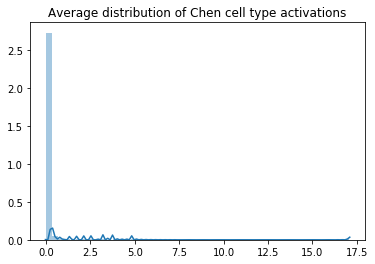

In [32]:
saly.plot_activation_distribution(chen_cell_activations, markers,
                                  title='Average distribution of Chen cell type activations')

In [28]:
saly.get_results(chen_labels, chen_cell_activations, markers, marker_aliases)

Correct predictions: 9439 out of 9687 (97.44%)


The network correctly classifies almost 100% of data from a completely new data set.

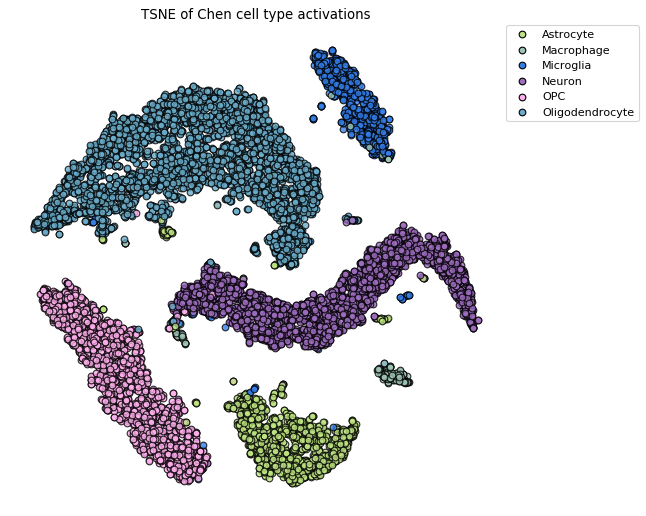

In [35]:
saly.draw_embedding(chen_cell_activations, chen_labels, tsne, colours=colours, alpha=0.8,
                    graph_title='TSNE of Chen cell type activations');

# Reconstruction

Here we took the Chen data set and run them through the autoencoder.

Then we took the autoencoder's output (i.e. the reconstructed data) and ran that data through the autoencoder again, this time looking at the Marker layer's cell type activations.

The cell type activations of the reconstructed data give similar, sometimes worse and sometimes better results.

In [29]:
reconstruction = model.predict(chen_data)[1]
reconstruction = pd.DataFrame(reconstruction, columns=chen_data.columns)
reconstructed_cell_activations = marker_model.predict(reconstruction)

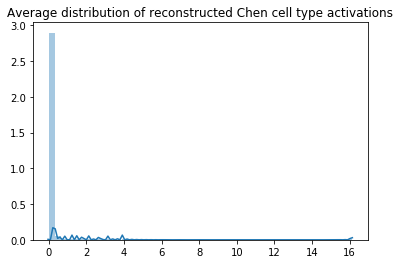

In [33]:
saly.plot_activation_distribution(reconstructed_cell_activations, markers,
                                  title='Average distribution of reconstructed Chen cell type activations')


In [30]:
saly.get_results(chen_labels, reconstructed_cell_activations, markers, marker_aliases)

Correct predictions: 9447 out of 9687 (97.52%)


The network correctly classifies almost 100% of reconstructed Chen data, similar to the original data.

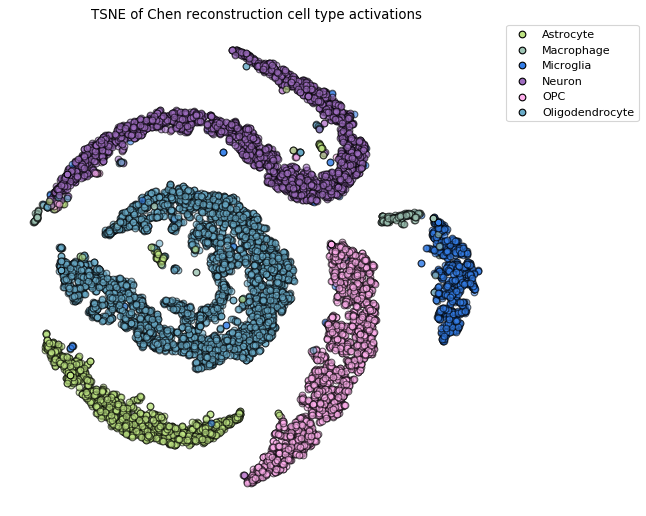

In [36]:
saly.draw_embedding(reconstructed_cell_activations, chen_labels, tsne, colours=colours, alpha=0.6,
           graph_title='TSNE of Chen reconstruction cell type activations');

# Combined data

Here we see if our marker activations still have batch effects.

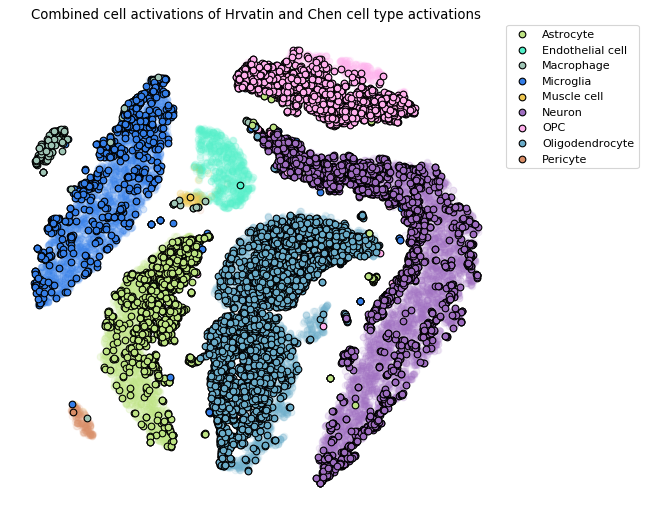

In [37]:
saly.draw_comparison([hrvatin_cell_activations, test_y], [chen_cell_activations, chen_labels] ,tsne, colours=colours,
                     graph_title='Combined cell activations of Hrvatin and Chen cell type activations')

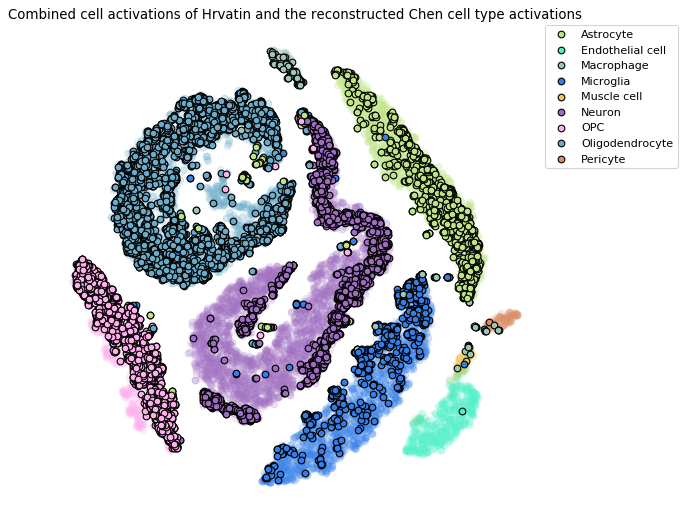

In [38]:
saly.draw_comparison([hrvatin_cell_activations, test_y], [reconstructed_cell_activations, chen_labels], tsne,
                     colours=colours, 
                     graph_title='Combined cell activations of Hrvatin and the reconstructed Chen cell type activations')

# Top 3 activations

We also tried to see if taking only the top 3 cell activations would help us remedy the batch effect.

In [39]:
hrvatin_top_3 = saly.get_top_activations(3, hrvatin_cell_activations)
chen_top_3 = saly.get_top_activations(3, chen_cell_activations)
reconstructed_top_3 = saly.get_top_activations(3, reconstructed_cell_activations)

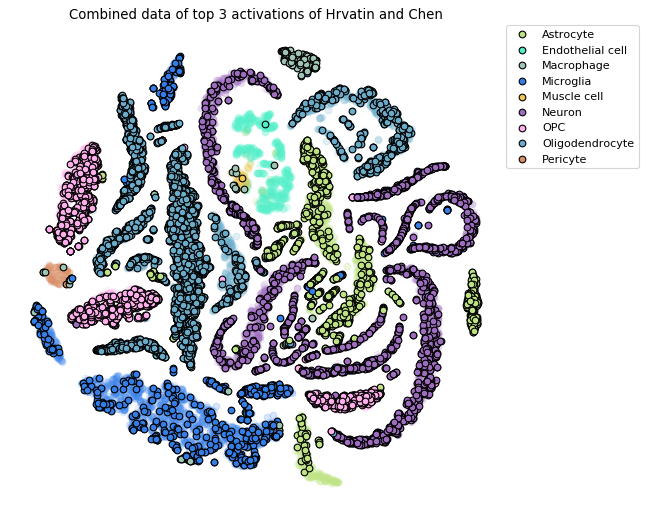

In [40]:
saly.draw_comparison([hrvatin_top_3, test_y], [chen_top_3, chen_labels], tsne, colours=colours,
                     graph_title='Combined data of top 3 activations of Hrvatin and Chen')

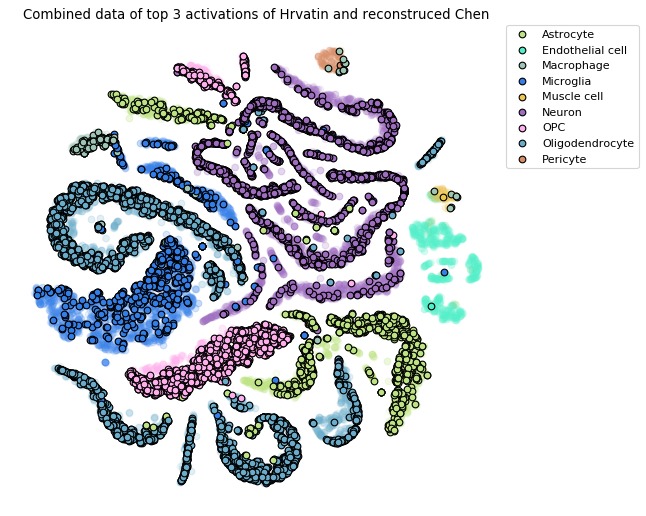

In [41]:
saly.draw_comparison([hrvatin_top_3, test_y], [reconstructed_top_3, chen_labels], tsne, colours=colours,
                     graph_title='Combined data of top 3 activations of Hrvatin and reconstruced Chen')